# Homework Project 3.  Due November 10

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse.linalg import eigsh
import hdbscan
import umap

np.random.seed(1)

### The attached file, 'polluteddeltas2.csv', contains the following data. 
### We took intraday price values for an asset, spanning a total of 45000 minutes.  This time series was then split into half-hour intervals for a total of 1500 intervals

In [12]:
# real data
df = pd.read_csv('./data/polluteddeltas2.csv', header=None)
df = df.iloc[:, 2:]

X = df.values
n, p = X.shape

# fake simulation
# n, p = 1500, 30
# X = np.random.normal(loc=0, scale=1, size=(n, p))
# t1, t2 = 10, 30
# X[t1:t2, :] = np.random.normal(loc=6, scale=1, size=(t2-t1, p))

In [13]:
c = X - X.mean(axis=0)
cov = (c.T @ c) / (n-1)

### There are 1500 lines in this file, one for each half-hour interval.  Each line begins with the count of the corresponding half-hour

In [6]:
# for t in range(3): #len(polluteddata[0,:])):
#     print('half-hour',t, 'data:',polluteddata[t,:]) 

### The data was constructed as follows for each half hour interval $t$.  Suppose that $p(t, k)$ denotes the price of the asset in minute $k$ of half-hour $t$.  Here $k = 0,1,\ldots, 29$.  
### The data in position $k+1$ of line $t$ of the file equals $p(t,k) - p(t,0)$, i.e. the change in price between minute $k$ and minute $0$.

### EXCEPT that:
### The data was <font color = "red">polluted</font> in a <font color = "red">significant and correlated</font> manner during a certain interval $[t_1, t_2]$ of half-hours.
### Your task is to identify this interval $[t_1, t_2]$ as closely as possible, using <font color = "red">covariance analysis techniques</font>.
### Please note that we are not interested in small, random noise.  We are looking for a large change in the covariance structure. 

In [45]:
k = 2
n_neigh, min_clust = 30, 15
use_pca = False

Y = None
metric = 'euclidean' if k <= 2 else 'canberra'
if use_pca:
    vals, vecs = eigsh(cov, k=k, which='LA') # pulling out k largest eigenvalues and associated eigenvectors
    vals, vecs = vals[::-1], np.flip(vecs, axis=1) # sorting by largest to smallest
    Y = X.dot(vecs) # projecting old data using the eigenvectors
else:
    reducer = umap.UMAP(n_neighbors=n_neigh, n_components=k, metric=metric, init='spectral', verbose=False)
    Y = reducer.fit_transform(X)

# take cluster size minimum to be 1% of n=1500, for example
clust = hdbscan.HDBSCAN(min_cluster_size=min_clust, metric=metric).fit(Y)
assgn, probs = clust.labels_, clust.probabilities_

df2 = pd.DataFrame(Y, columns=[f'PC{i}' if use_pca else f'UMAP{i}' for i in range(1, k+1)])
df2['cluster'], df2['cluster_probability'] = assgn, probs

polluted_clusters = df2['cluster'].value_counts(ascending=True).index.tolist()[:-1]

In [46]:
polluted_indices_empirical = set(df2[df2['cluster'].isin(polluted_clusters)].index.tolist())
polluted_indices_guess = set(list(range(800, 1001)))

polluted_indices_empirical.difference(polluted_indices_guess)

set()

Clusters present (-1 is noise): [0, 1, 2]


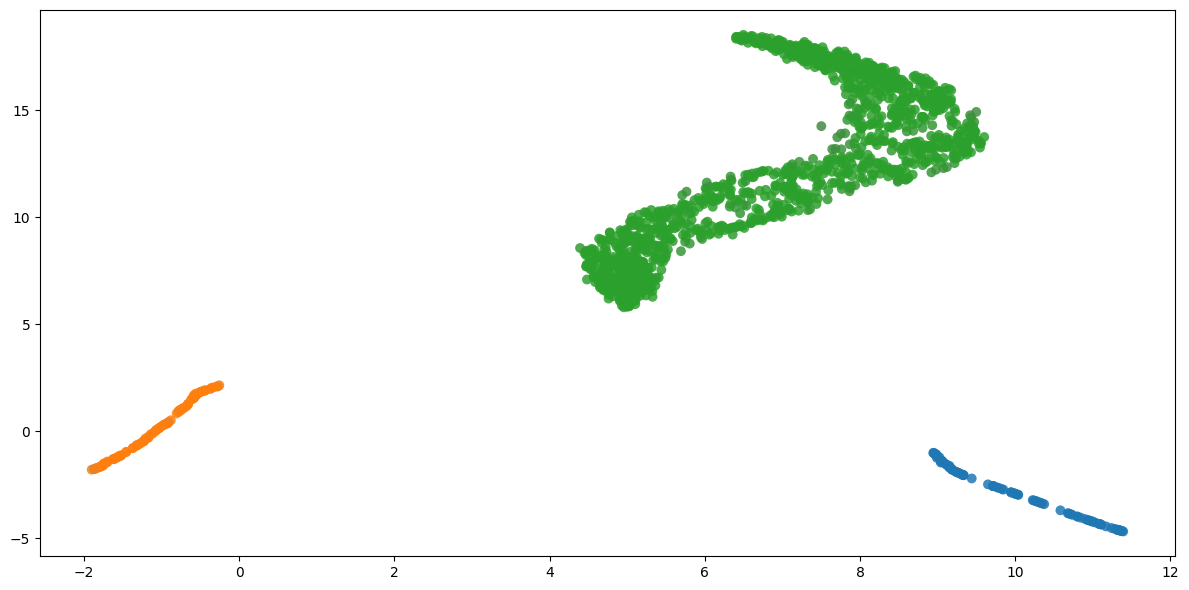

In [47]:
# VISUALIZATION CODE ONLY MAKES SENSE FOR K = 2 (CAN ONLY GRAPH IN 2 DIMENSIONS)
unq_assgn = set(assgn)
print('Clusters present (-1 is noise):', sorted(unq_assgn))

color_palette = sns.color_palette('tab10', len(unq_assgn) - (1 if -1 in unq_assgn else 0))
cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in assgn]
cluster_member_colors = [sns.desaturate(x, p) for x, p in zip(cluster_colors, probs)]

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.scatter(x=Y[:, 0], y=Y[:, 1], c=cluster_member_colors, s=50, linewidth=0, alpha=0.85)

plt.tight_layout()
plt.show()